In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [9]:
# Define the path to the 'free' subfolder
csv_folder_path = "processed_data"

# Read the csv file into a pandas dataframe
df_label_scores = pd.read_csv(os.path.join(csv_folder_path, "label_scores_accuracy_summary.csv"))


df_label_scores = df_label_scores.drop(columns=['metric_formula'])
print(df_label_scores.head())

          model_name       phenomenon       metric  dependent_variable
0  google/flan-t5-xl        coherence  label_score              0.5325
1  google/flan-t5-xl          deceits  label_score              0.2050
2  google/flan-t5-xl           humour  label_score              0.1560
3  google/flan-t5-xl  indirect_speech  label_score              0.2250
4  google/flan-t5-xl            irony  label_score              0.2680


In [7]:
# Read the csv file into a pandas dataframe
df_free = pd.read_csv(os.path.join(csv_folder_path, "free_accuracy_summary.csv"))
print(df_free.head())

        phenomenon  dependent_variable model_name         metric
0        coherence            0.856684      human  forced_choice
1          deceits            0.841979      human  forced_choice
2           humour            0.846845      human  forced_choice
3  indirect_speech            0.885963      human  forced_choice
4            irony            0.919465      human  forced_choice


In [8]:
# Read the csv file into a pandas dataframe
df_rating = pd.read_csv(os.path.join(csv_folder_path, "rating_accuracy_summary.csv"))
print(df_rating.head())

          model_name phenomenon  dependent_variable  metric
0  google/flan-t5-xl  coherence            0.475000  rating
1  google/flan-t5-xl    deceits            0.050000  rating
2  google/flan-t5-xl     humour            0.240000  rating
3  google/flan-t5-xl      irony            0.480000  rating
4  google/flan-t5-xl     maxims            0.105263  rating


In [16]:
# Concat alal three dataframes
df_all = pd.concat([df_label_scores, df_free, df_rating])
df_all = df_all.reset_index(drop=True, inplace=False)
df_all[df_all['model_name'] == 'human']

,model_name,phenomenon,metric,dependent_variable
168,human,coherence,forced_choice,0.856684
169,human,deceits,forced_choice,0.841979
170,human,humour,forced_choice,0.846845
171,human,indirect_speech,forced_choice,0.885963
172,human,irony,forced_choice,0.919465
173,human,maxims,forced_choice,0.795856
174,human,metaphor,forced_choice,0.896791


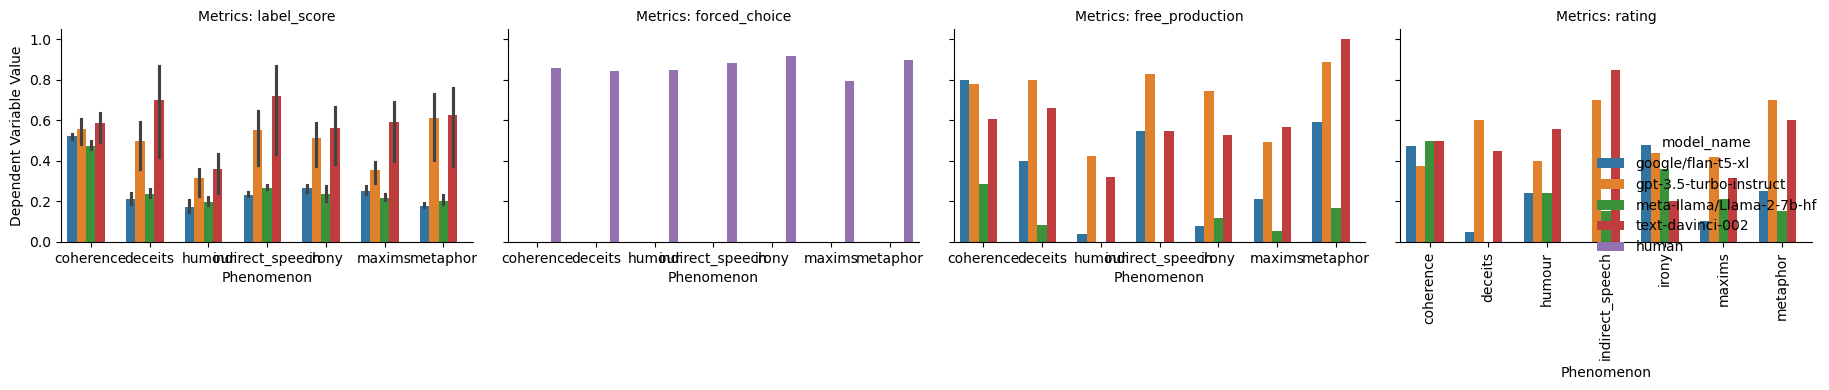

In [17]:
g = sns.catplot(data=df_all, 
                x='phenomenon', 
                y='dependent_variable', 
                hue='model_name', 
                col='metric', 
                kind='bar', 
                height=4, 
                aspect=1)

g.set_axis_labels("Phenomenon", "Dependent Variable Value")
g.set_titles("Metrics: {col_name}")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
